# Notebook to generate performance plot for each monkey.

This notebook requires the processed behavior data for the triangle task, saved
in `../../../cache/behavior/triangle.csv`. This can be downloaded from the OSF
repo or can be generated by running the script
`../../../behavior_processing/run_cache_data.py`.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../../../behavior_processing')
import load_ring_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load data."""

df = load_ring_data.load_data()

# Add response_to_objects column to ring data
response_to_objects = []
for _, row in df.iterrows():
    response_object_0 = row['response_object_0']
    response_object_1 = row['response_object_1']
    if response_object_0 or response_object_1:
        response_to_objects.append(True)
    else:
        response_to_objects.append(False)
df['response_to_objects'] = response_to_objects

# Combine dataframes
keep_columns = ["num_objects", "correct", "subject", "response_to_objects", "reaction_time", "completed"]
df = df[keep_columns]
df = df[df['completed'] == True]

# Rename subject column to "P" and "E" instead of "Perle" and "Elgar"
df["subject"] = df["subject"].apply(lambda x: x[0])

# Convert reaction time from seconds to milliseconds
df["Reaction time (ms)"] = df["reaction_time"] * 1000
df = df.drop(columns=["reaction_time"])

# Create a new column "Correct" with values "Correct" or "Incorrect"
df["Correct"] = df["correct"].apply(lambda x: "Correct" if x else "Incorrect")

Monkey P, 1 objects, performance: 0.958
Monkey P, 2 objects, performance: 0.903
Monkey P, 1 objects, response-to-object performance: 1.0
Monkey P, 2 objects, response-to-object performance: 0.92
Monkey E, 1 objects, performance: 0.945
Monkey E, 2 objects, performance: 0.756
Monkey E, 1 objects, response-to-object performance: 1.0
Monkey E, 2 objects, response-to-object performance: 0.773
1 objects, performance: 0.951
2 objects, performance: 0.821
1 objects, response-to-object performance: 1.0
2 objects, response-to-object performance: 0.838


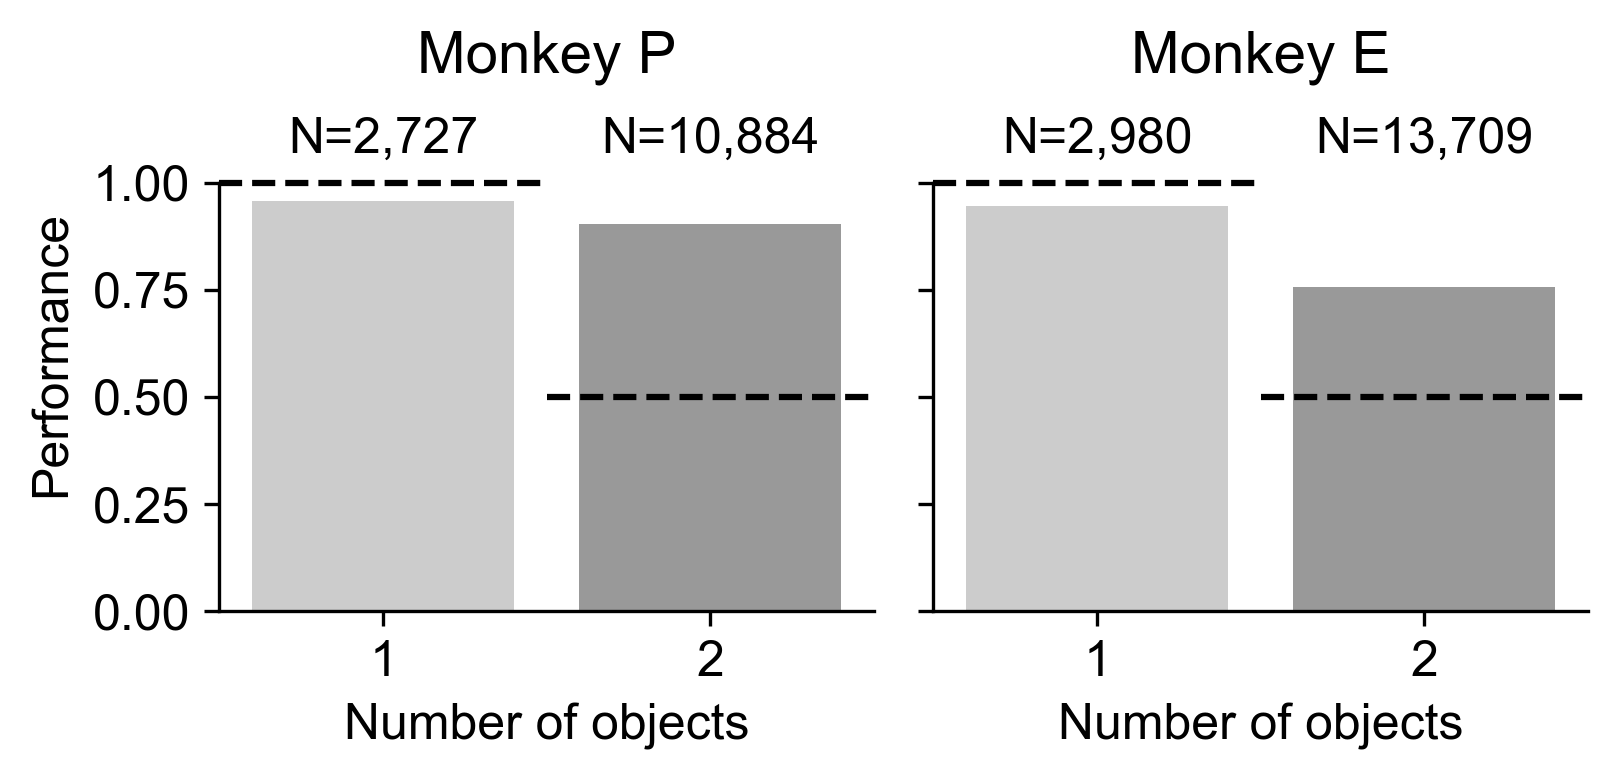

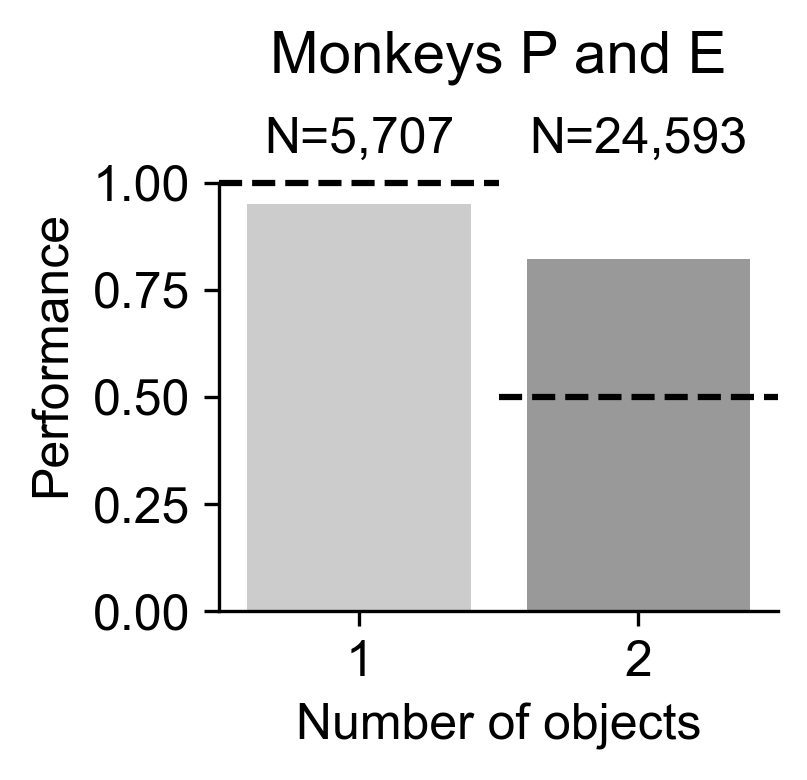

In [3]:
""""Plot average performance per subject."""

PALETTE = {
    1: (0.8, 0.8, 0.8),
    2: (0.6, 0.6, 0.6),
    3: (0.4, 0.4, 0.4),
}

def plot_performance(df, ax):
    sns.despine(ax=ax)
    sns.barplot(
        ax=ax, data=df,
        x='num_objects', y='correct',
        hue="num_objects",
        palette=PALETTE,
        errorbar=None,
        legend=False,
    )
    ax.set_xlabel('Number of objects')
    ax.set_ylabel('Performance')
    ax.spines['left'].set_bounds(0, 1)
    
    # Add horizontal line at 0.5 for Number of objects = 1
    ax.axhline(1., color='black', linestyle='--', xmin=0, xmax=0.5)
    
    # Add horizontal line at 0.5 for Number of objects = 2
    ax.axhline(0.5, color='black', linestyle='--', xmin=0.5, xmax=1)
    
    # For each number of objects, add text for number of trials
    ax.set_ylim(0, 1.2)
    for n in range(1, 3):
        n_trials = df[df['num_objects'] == n].shape[0]
        n_trials_string = '{:,}'.format(n_trials)
        ax.text(n - 1, 1.1, f'N={n_trials_string}', ha='center', va='center', fontsize=12)

# Performance per subject
fig, axes = plt.subplots(1, 2, figsize=(5.4, 2.7), sharey=True)
for subject, ax in zip(['P', 'E'], axes):
    subject_df = df[df['subject'] == subject]
    plot_performance(subject_df, ax)
    ax.set_title(f'Monkey {subject}')
    
    # Print performance for each number of objects
    for n in range(1, 3):
        performance = subject_df[subject_df['num_objects'] == n]['correct'].mean()
        performance = round(performance, 3)
        print(f'Monkey {subject}, {n} objects, performance: {performance}')
        
    # Print performance for each number of objects, given responded to some object
    for n in range(1, 3):
        performance = subject_df[
            (subject_df['num_objects'] == n)
            & (subject_df['response_to_objects'])
        ]['correct'].mean()
        performance = round(performance, 3)
        print(f'Monkey {subject}, {n} objects, response-to-object performance: {performance}')

# Save figure
fig.tight_layout()
plt.savefig('./plots/performance_per_subject.pdf', bbox_inches='tight', pad_inches=0.01)

# Performance combined over subjects
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.7))
plot_performance(df, ax)
ax.set_title(f'Monkeys P and E')

# Print performance for each number of objects
for n in range(1, 3):
    performance = df[df['num_objects'] == n]['correct'].mean()
    performance = round(performance, 3)
    print(f'{n} objects, performance: {performance}')
    
# Print performance for each number of objects, given responded to some object
for n in range(1, 3):
    performance = df[
        (df['num_objects'] == n)
        & (df['response_to_objects'])
    ]['correct'].mean()
    performance = round(performance, 3)
    print(f'{n} objects, response-to-object performance: {performance}')

# Save figure
fig.tight_layout()
plt.savefig('./plots/performance_combined.pdf', bbox_inches='tight', pad_inches=0.01)

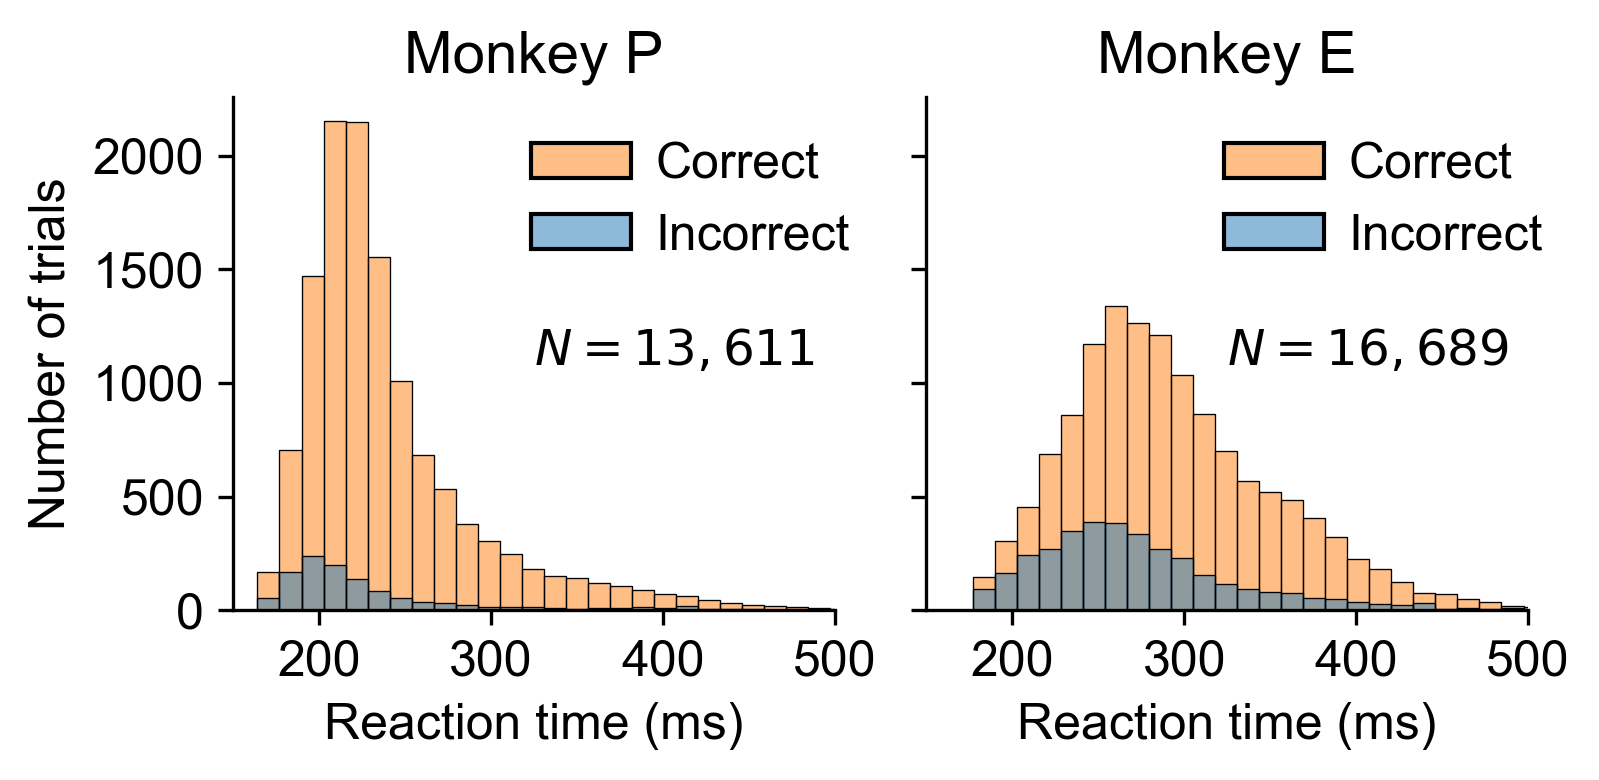

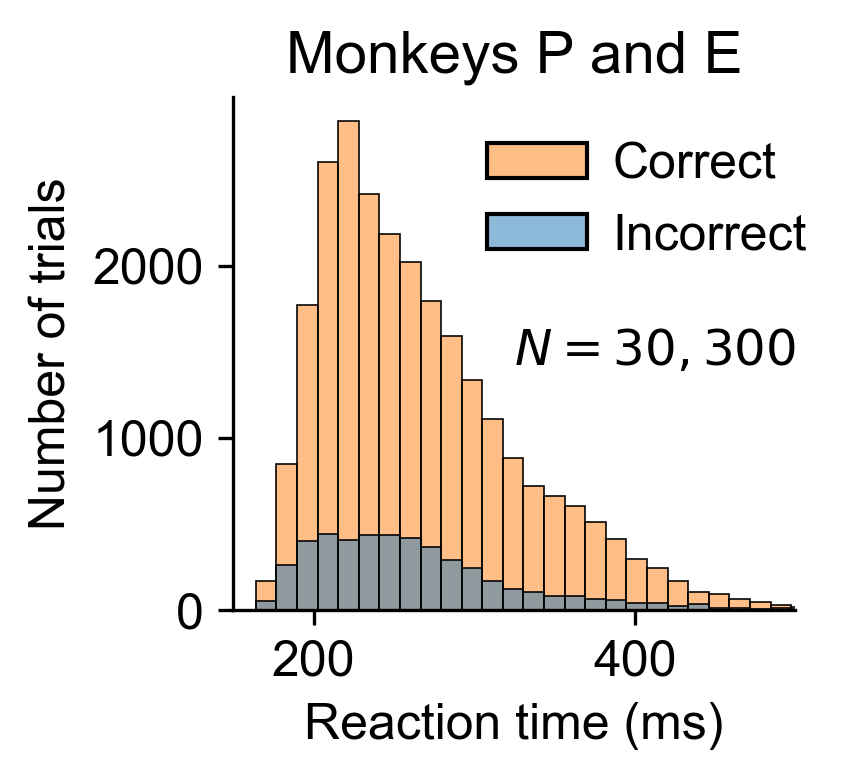

In [5]:
""""Plot reaction time distribution."""

def plot_reaction_time(df, ax):
    sns.despine(ax=ax)
    sns.histplot(
        data=df,
        x='Reaction time (ms)',
        hue='Correct',
        ax=ax,
        bins=np.linspace(100, 600, 40),
        common_norm=False,
        hue_order=["Incorrect", "Correct"],
    )
    ax.set_ylabel('Number of trials')
    n_trials = df.shape[0]

    # Format with columns for thousands
    n_trials_string = '{:,}'.format(n_trials)
    ax.text(0.5, 0.55, f'$N = {n_trials_string}$', transform=ax.transAxes, verticalalignment='top', fontsize=12)

    # Adjust x-axis limits
    ax.set_xlim(150, 500)

    # Make legend with no title, and with labels "Incorrect" and "Correct"
    sns.move_legend(
        ax,
        "upper right",
        title=None,
        bbox_to_anchor=(1.1, 1.0),
        frameon=False,
        fontsize=12,
        reverse=True,
        handletextpad=0.5,
    )

# Histogram reaction time per subject
fig, axes = plt.subplots(1, 2, figsize=(5.4, 2.7), sharey=True)
for subject, ax in zip(['P', 'E'], axes):
    df_subject = df[df['subject'] == subject]
    plot_reaction_time(df_subject, ax)
    ax.set_title(f'Monkey {subject}')
fig.tight_layout()
fig.savefig('./plots/reaction_time_per_subject.pdf', bbox_inches='tight', pad_inches=0.01)


# Histogram reaction time combined over subjects
fig, ax = plt.subplots(1, 1, figsize=(3., 2.7))
plot_reaction_time(df, ax)
ax.set_title(f'Monkeys P and E')
fig.tight_layout()
fig.savefig('./plots/reaction_time_combined.pdf', bbox_inches='tight', pad_inches=0.01)